In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import scipy.io

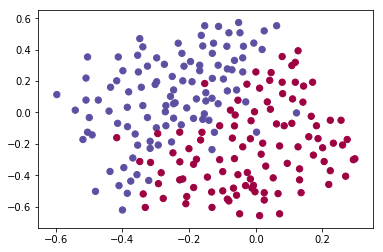

In [14]:
# 导入数据、可视化

data = scipy.io.loadmat('data.mat')
train_X = data['X'].T
train_Y = data['y'].T
test_X = data['Xval'].T
test_Y = data['yval'].T

plt.scatter(train_X[0, :], train_X[1, :], c=train_Y[0, :], s=40, cmap=plt.cm.Spectral);

In [3]:
# 决策边界

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y[0,:], cmap=plt.cm.Spectral)
    plt.show()
    
def predict_dec(parameters, X): # 预测
    
    a3, cache = forward_propagation(X, parameters)
    predictions = (a3>0.5)
    
    return predictions

In [6]:
# 参数初始化

def initialize_parameters_he(layers_dims): 
    
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) - 1
     
    for l in range(1, L + 1):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1]) * np.sqrt(1.0/(layers_dims[l-1]))
        parameters['b' + str(l)] = np.zeros((layers_dims[l],1))
    return parameters

In [20]:
# 正向传播

def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

def relu(x):
    s = np.maximum(0,x)
    return s

def forward_propagation(X, parameters):

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    z1 = np.dot(W1, X) + b1
    a1 = relu(z1)
    z2 = np.dot(W2, a1) + b2
    a2 = relu(z2)
    z3 = np.dot(W3, a2) + b3
    a3 = sigmoid(z3)
    
    cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3)
    
    return a3, cache

def compute_cost_with_regularization(A3, Y, parameters, lambd): # L2正则化
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y)
    L2_regularization_cost = lambd*(np.sum(np.square(W1))+np.sum(np.square(W2))+np.sum(np.square(W3)))/(2*m) #L2正则化项
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5): # Dropout

    np.random.seed(1)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    D1 = np.random.rand(A1.shape[0],A1.shape[1]) # Dropout                                     
    D1 = D1 < keep_prob                                         
    A1 = np.multiply(A1,D1)                                        
    A1 = A1 / keep_prob                                        
   
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    D2 = np.random.rand(A2.shape[0],A2.shape[1])                                        
    D2 = D2 < keep_prob                                         
    A2 = np.multiply(A2,D2)                                         
    A2 = A2 / keep_prob                                         

    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [21]:
# 反向传播

def backward_propagation(X, Y, cache):
    
    m = X.shape[1]
    (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache
    
    dz3 = 1./m * (a3 - Y)
    dW3 = np.dot(dz3, a2.T)
    db3 = np.sum(dz3, axis=1, keepdims = True)
    
    da2 = np.dot(W3.T, dz3)
    dz2 = np.multiply(da2, np.int64(a2 > 0))
    dW2 = np.dot(dz2, a1.T)
    db2 = np.sum(dz2, axis=1, keepdims = True)
    
    da1 = np.dot(W2.T, dz2)
    dz1 = np.multiply(da1, np.int64(a1 > 0))
    dW1 = np.dot(dz1, X.T)
    db1 = np.sum(dz1, axis=1, keepdims = True)
    
    gradients = {"dz3": dz3, "dW3": dW3, "db3": db3,
                 "da2": da2, "dz2": dz2, "dW2": dW2, "db2": db2,
                 "da1": da1, "dz1": dz1, "dW1": dW1, "db1": db1}
    
    return gradients

def update_parameters(parameters, grads, learning_rate): # 更新参数
    
    n = len(parameters) // 2 
    for k in range(n):
        parameters["W" + str(k+1)] = parameters["W" + str(k+1)] - learning_rate * grads["dW" + str(k+1)]
        parameters["b" + str(k+1)] = parameters["b" + str(k+1)] - learning_rate * grads["db" + str(k+1)]
        
    return parameters

def backward_propagation_with_regularization(X, Y, cache, lambd): # L2正则化后反向传播
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    
    dW3 = 1./m * np.dot(dZ3, A2.T) + lambd*W3/m
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T) + lambd*W2/m
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T) + lambd*W1/m
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

def backward_propagation_with_dropout(X, Y, cache, keep_prob): # Dropout下反向传播
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dA2 = np.multiply(dA2,D2)              
    dA2 = dA2 / keep_prob              
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dA1 = np.multiply(dA1,D1)              
    dA1 = dA1 / keep_prob              
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [26]:
# 预测结果

def predict(X, y, parameters):

    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    a3, caches = forward_propagation(X, parameters)

    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    print("识别准确度: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

In [22]:
# 整个模型

def model(X, Y, learning_rate = 0.01, layers_dims = [], num_iterations = 15000, lambd = 0, keep_prob = 1,  print_cost = True):
        
    grads = {}
    costs = []                          
    m = X.shape[1]                      
    
    parameters = initialize_parameters_he(layers_dims)
  
    for i in range(0, num_iterations):

        # 前向传播: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # 损失函数
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd) #L2正则化
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob) #DropOut正则化
        
        # 更新参数 
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 3000 == 0:
            print("循环{}次后的成本值: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # 画出成本曲线
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

----------无正则化----------
循环0次后的成本值: 0.6557412523481002
循环3000次后的成本值: 0.18251497924686955
循环6000次后的成本值: 0.1683273039211542
循环9000次后的成本值: 0.1594261225324511
循环12000次后的成本值: 0.15764474148193003
循环15000次后的成本值: 0.14796400922574193
循环18000次后的成本值: 0.1433508853738147
循环21000次后的成本值: 0.1411867835179103
循环24000次后的成本值: 0.1303232600203372
循环27000次后的成本值: 0.13263846518808448


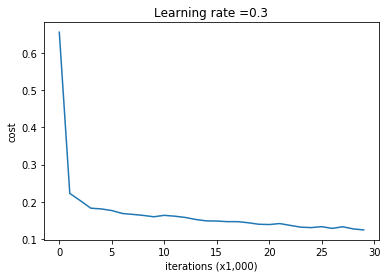

----------L2正则化----------
循环0次后的成本值: 0.6974484493131264
循环3000次后的成本值: 0.269508280641266
循环6000次后的成本值: 0.26889745607345616
循环9000次后的成本值: 0.2685595174585008
循环12000次后的成本值: 0.268370115369031
循环15000次后的成本值: 0.2682199033729048
循环18000次后的成本值: 0.26813316999149156
循环21000次后的成本值: 0.26803821899502356
循环24000次后的成本值: 0.2678953595054706
循环27000次后的成本值: 0.2679162550106563


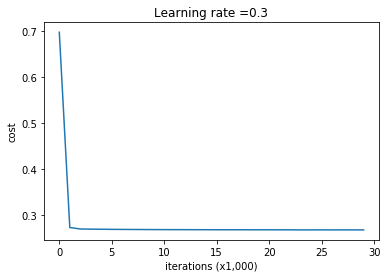

----------Dropout----------
循环0次后的成本值: 0.6543912405149825
循环3000次后的成本值: 0.07661297787357768


/home/hugsy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
/home/hugsy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in multiply


循环6000次后的成本值: 0.06240987259698132
循环9000次后的成本值: 0.061192143757634855
循环12000次后的成本值: 0.06082640196596114
循环15000次后的成本值: 0.06066457216128777
循环18000次后的成本值: 0.06065874505596672
循环21000次后的成本值: 0.060559199380913156
循环24000次后的成本值: 0.060503590269931996
循环27000次后的成本值: 0.060473147392254074


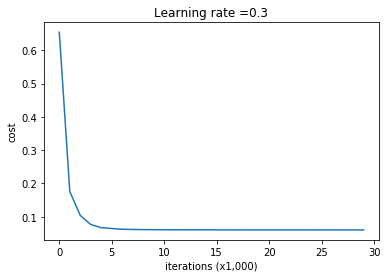

In [23]:
# 成本变化对比

layers = [train_X.shape[0], 20, 3, 1] # 各层节点数

print('----------无正则化----------')
parameters_no_reg = model(train_X, train_Y, layers_dims = layers, learning_rate = 0.3, num_iterations = 30000)
print('----------L2正则化----------')
parameters_L2_reg = model(train_X, train_Y, layers_dims = layers, learning_rate = 0.3, num_iterations = 30000, lambd = 0.7)
print('----------Dropout----------')
parameters_dropout_reg = model(train_X, train_Y, layers_dims = layers, learning_rate = 0.3, num_iterations = 30000, keep_prob = 0.86)

----------无正则化----------


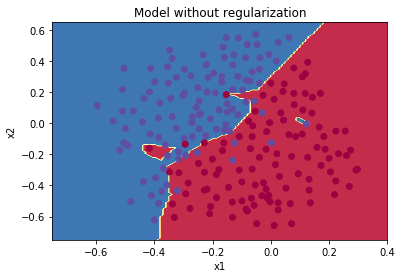

训练集中:
识别准确度: 0.9478672985781991
测试集中:
识别准确度: 0.915
----------L2正则化----------


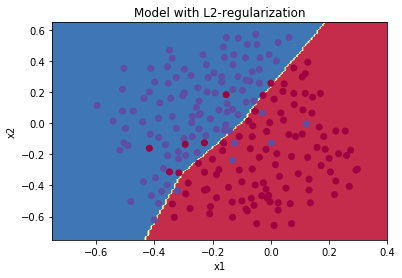

训练集中:
识别准确度: 0.9383886255924171
测试集中:
识别准确度: 0.93
----------Dropout----------


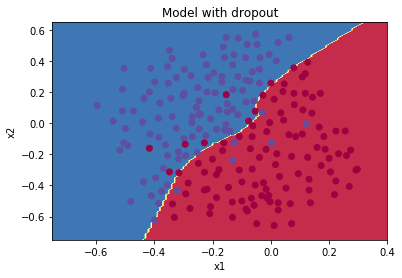

训练集中:
识别准确度: 0.9289099526066351
测试集中:
识别准确度: 0.95


In [27]:
# 决策边界、预测准确度对比

print('----------无正则化----------')
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters_no_reg, x.T), train_X, train_Y)
print ("训练集中:")
predictions_train = predict(train_X, train_Y, parameters_no_reg)
print ("测试集中:")
predictions_test = predict(test_X, test_Y, parameters_no_reg)

print('----------L2正则化----------')
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters_L2_reg, x.T), train_X, train_Y)
print ("训练集中:")
predictions_train = predict(train_X, train_Y, parameters_L2_reg)
print ("测试集中:")
predictions_test = predict(test_X, test_Y, parameters_L2_reg)

print('----------Dropout----------')
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters_dropout_reg, x.T), train_X, train_Y)
print ("训练集中:")
predictions_train = predict(train_X, train_Y, parameters_dropout_reg)
print ("测试集中:")
predictions_test = predict(test_X, test_Y, parameters_dropout_reg)